Processing SALSA 21cm Data.

This Notebook will go through how to process data from SALSA (https://liv.oso.chalmers.se/salsa/) and create a rotation curve for the Milky Way.
It should be as simple as collecting data from a range of galactic longitudes and putting them into a adjacent folder named 'data'.

The first step is to import relevant modules, as well as general setup.

In [161]:
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [9, 4]
plt.rcParams["figure.autolayout"] = True

fileSM = "processed/salsa_max.txt"
fileSP = "processed/salsa_peak.txt"

with open(fileSM, "w") as f1, open(fileSP, "w") as f2:
    pass

Next we will rename the files with their galactic coordinates.

In [162]:
#Define the directory path where the files are located
directory = 'data'

#Get a list of all the files in the directory
files = os.listdir(directory)

#Loop through each file
for filename in files:

    #Open the file and read the contents
    with open(os.path.join(directory, filename), 'r') as f:
        contents = f.readlines()

        #Get the GLON and GLAT values from the file and round to 2 d.p.
        GLON = round(float(contents[4].strip()[7:]), 2)
        GLAT = round(float(contents[5].strip()[7:]), 2)

        #Format the GLON and GLAT to be 2 d.p. even if ending with zero.
        GLON_str = '{:.2f}'.format(GLON).zfill(3)
        GLAT_str = '{:.2f}'.format(GLAT).zfill(3)

    #Rename the file
    new_filename = f'{GLON_str}_{GLAT_str}.txt'
    os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))



A useful but not required step is to map the galactic coordinates to see what results were collected.

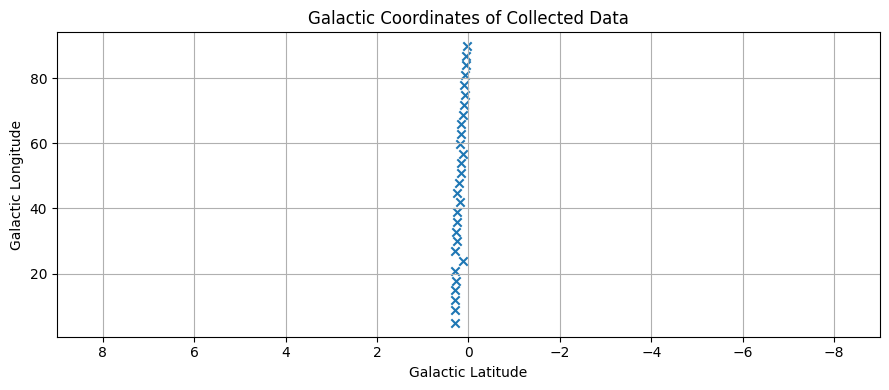

In [163]:
#Script to plot galactic coordinates of collected data from SALSA telescope.

directory = 'data'
#Name of main folder.

files = os.listdir(directory)
#Create a list of files.

xCoords = []
yCoords = []
#Empty list of coordinates.

for f in files:
    spectrum = os.path.join(directory, f)
    #Attach directory to file names
    spectrumOpen = open(spectrum)
    #Open files
    content = spectrumOpen.readlines()
    #Read files
    yCoords.append(float(content[4].replace('# GLON=','').strip()))
    xCoords.append(float(content[5].replace('# GLAT=','').strip()))
    #Takes number from each coordinate line and adds to list.
    spectrumOpen.close()

plt.scatter(xCoords, yCoords, marker="x")
plt.title('Galactic Coordinates of Collected Data')
plt.ylabel('Galactic Longitude')
plt.xlabel('Galactic Latitude')
plt.xlim(9,-9)
plt.grid()
plt.savefig('Data_Coords.png')
#Plots the galactic coordinates of the given data.

Now we are going to plot the spectra labeling the max (red) and peak (blue) velocities. Running this repeatedly will overwrite previous diagrams with same name. The spectra are saved to a folder called 'plots' which will be created if not already existing

In [164]:
def plot_spectrum(filename, peak_threshold=0.2):
   
    # Load spectrum data from file
    vel, P = np.loadtxt('data/{}'.format(filename), skiprows=8, unpack=True)

    # Find the peak velocities and intensities
    max_intensity = np.max(P)
    peak_indices = np.where(P >= 0.8 * max_intensity)[0]
    peak_velocities = vel[peak_indices]
    peak_intensities = P[peak_indices]

    # Find the velocity of the peak with the greatest x value
    peak_index = np.argmax(peak_velocities)
    peak_velocity = peak_velocities[peak_index]
    peak_intensity = peak_intensities[peak_index]

    # Find the velocity corresponding to the specified threshold intensity
    threshold_intensity = peak_threshold * peak_intensity
    threshold_index = np.argmin(abs(P[:peak_indices[peak_index]] - threshold_intensity))
    threshold_velocity = vel[threshold_index]

    # Plot the data and vertical lines
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(r"Velocity (km s$^{-1}$)")
    ax1.set_ylabel(r"Intensity (counts)")
    ax1.ticklabel_format(axis='x', style='plain')
    ax1.plot(vel, P, linestyle='-', color='k')

    mlinex = [peak_velocity, peak_velocity] 
    mliney = [0, peak_intensity + 10]
    plinex = [threshold_velocity, threshold_velocity] 
    pliney = [0, peak_intensity + 10]
    ax1.plot(mlinex, mliney, linestyle='dotted', color='red') 
    ax1.plot(plinex, pliney, linestyle='dotted', color='blue')

    GLON_GLAN = filename[:-4].split('_')
    GLON_file = float(GLON_GLAN[0])

    with open(fileSM, "a") as f1, open(fileSP, "a") as f2:
        f1.write('{} {}\n'.format(GLON_file, threshold_velocity))
        f2.write('{} {}\n'.format(GLON_file, peak_velocity))

    plt.tight_layout()
    plt.title('(GLAN_GLON) = ' + filename[:-4])
    plt.grid()
    plt.savefig('plots/{}.png'.format(filename[:-4]))
    plt.close()

#Define the directory path where the files are located
directory = 'data'

#Get a list of all the files in the directory
files = os.listdir(directory)

# Create the 'plots' directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

for f in files:
    plot_spectrum(f, 0.2)

Process the example data and collected data.

In [165]:
#Model from (McGaugh, 2018, RNAAS, 2, 156).
Rm,Vbm,Vgm,Vkm,Vdm,Vm,Vcm = np.loadtxt("processed/McGaugh_model.txt", skiprows=3, unpack = True)
#Data from (McClure-Griffiths & Dickey, 2007, ApJ, 671, 427).
Rc,Vc = np.loadtxt("processed/McClure07.txt", skiprows=3, unpack = True)
#Our SALSA data (measured at edge of largest velocity).
glonM,V0M = np.loadtxt("processed/salsa_max.txt", unpack = True)
#Our SALSA data (measured at highest peak in velocity).
glonP,V0P = np.loadtxt("processed/salsa_peak.txt", unpack = True)

Solar Values

In [166]:
vsun = 220  # km/s (Salsa)
rsun = 8.5  # kpc (Salsa)
##vsun = 233  # km/s (McGaugh)
##rsun = 8.12  # kpc (McGaugh)

vsinl = vsun * np.sin( glonM * np.pi / 180.)
rsinl = rsun * np.sin( glonM * np.pi / 180.)
rcosl = rsun * np.cos( glonM * np.pi / 180.)

Estimate errors and calculate rotational velocities.

In [167]:
vread = 5 # km/s (assumed error in velocity calculation)

vrotM = V0M + vsinl  # edge of largest velocity
vrotP = V0P + vsinl  # highest peak in velocity

Plot rotation curve.

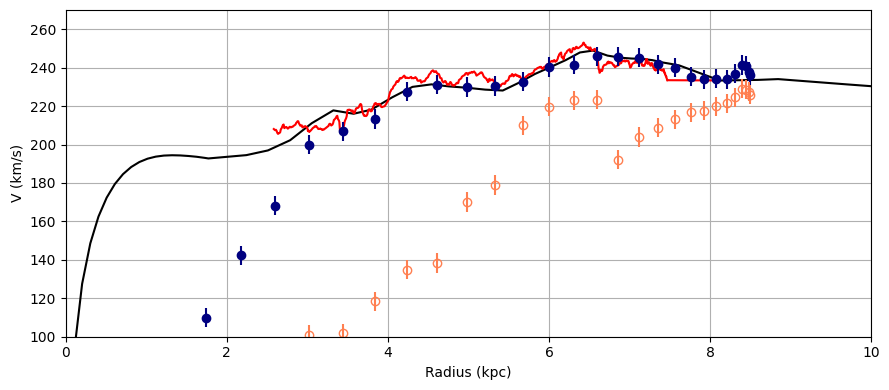

In [168]:
fig, ax1 = plt.subplots()
ax1.set_xlabel(r"Radius (kpc)")
ax1.set_ylabel(r"V (km/s)")
ax1.set_xlim(0, 10)
ax1.set_ylim(100, 270)
ax1.ticklabel_format(axis='x', style='plain')
ax1.plot(Rm,Vm, linestyle='-',color='k') ## total McGaugh model
ax1.plot(Rc,Vc, linestyle='-', color='red') ## McClure data
ax1.errorbar(rsinl,vrotM, yerr=vread, fmt='o', color='navy')
ax1.errorbar(rsinl,vrotP, yerr=vread, fmt='o', fillstyle='none', color='coral')
plt.tight_layout()
plt.grid()
plt.savefig('Rotation_Curve.png')